# Mammalian Enhancer Classification with Genomic Pretraining and Fine Tuning 3-mer stride 1 Model

This notebook uses the enhancer dataset to fine tune the mammalian language model and train a classification model via transfer learning. For more detail about the fine tuning process, see the [Human 4 Short Promoter Classification with Fine Tuning](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Mammals/Human/Promoter%20Classification%20Short%20Sequences/Human%20Promoters%20Short%20Sequences%203%20Classification%20with%20Fine%20Tuning.ipynb) notebook.

To replicate a portion of the paper, the model will be trained on enhancer sequences from Human, Mouse, Dog and Opossum genomes. The multi-species model will then be used to predict on individual species.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
from sklearn.metrics import roc_auc_score

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/mammals/')

# Human

In [5]:
classification_df = pd.read_csv(path/'enhancer_data.csv')

In [6]:
classification_df.head()

,Sequence,Enhancer,Organism,set
0,TGCGGGGTCTTGGCTCTCACGGTCGACTCTGCCTCTCGTGCCCGGG...,positive,Cat,train
1,TCCAGCCACTCCTGAGTCAACATGGCGGGCTTTCTTTGTTGGGCTC...,positive,Cat,train
2,GTGTGCTGGCCACCAGAGGGAGCCAGATCCCCCCTTTTCTCCTCCA...,positive,Cat,train
3,TGGGCGTTTTCACTGCGCGGTCTCTGCTCCTGCCCAACCGCAAGCG...,positive,Cat,train
4,GGCATTGGAGGGACCGAGAATAGGGAGGCCCTGGCCCAAAAAATCA...,positive,Cat,train


In [7]:
classification_df = classification_df[classification_df.Organism == 'Human']

In [8]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [9]:
classification_df.Organism.unique()

array(['Human'], dtype=object)

In [10]:
train_df.shape, valid_df.shape, test_df.shape

((22400, 4), (2800, 4), (2800, 4))

In [11]:
voc = np.load(path/'mammal_vocab_3m1s.npy')
model_vocab = GenomicVocab(voc)

In [12]:
len(model_vocab.itos)

65

In [13]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=3, stride=1), n_cpus=8, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [14]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=850, tokenizer=tok, 
                              chunksize=80000, text_cols='Sequence', label_cols='Enhancer', vocab=model_vocab)

In [15]:
len(data.vocab.stoi), len(data.vocab.itos)

(65, 65)

In [18]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [19]:
learn = get_model_LM(data, drop_mult, config)

In [20]:
learn = learn.to_fp16(dynamic=True);
learn.load('mammal_3m1s');

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


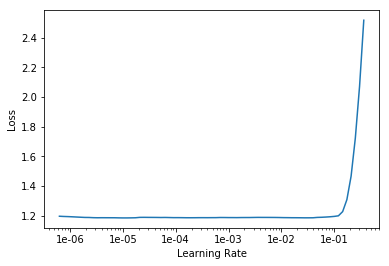

In [23]:
learn.recorder.plot()

# Training


In [22]:
learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.185968,1.177399,0.454623,02:04
1,1.182650,1.177281,0.454949,02:04
2,1.183790,1.177529,0.454880,02:05
3,1.179468,1.177399,0.454905,02:05
4,1.178157,1.177614,0.454821,02:05
5,1.170979,1.177720,0.454604,02:05
6,1.173816,1.177741,0.454716,02:05
7,1.172514,1.177812,0.454727,02:05


In [23]:
learn.save('enhancer_human_LM_3m1s')
learn.save_encoder('enhancer_human_LM_3m1s_enc')

# Classification

In [14]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab, chunksize=80000,
                                            text_cols='Sequence', label_cols='Enhancer', bs=200)

In [15]:
len(data_clas.vocab.itos), len(data_clas.vocab.stoi)

(65, 65)

In [18]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4,
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.55

In [19]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [20]:
learn = learn.to_fp16(dynamic=True);

In [21]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(65, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(65, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.22000000000000003)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05,

In [21]:
learn.load_encoder('enhancer_human_LM_3m1s_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


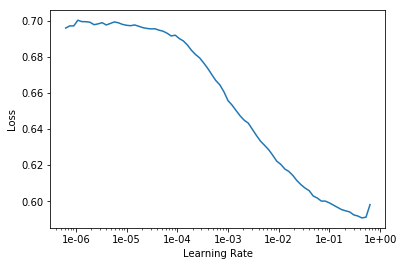

In [22]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(3, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.550325,0.559085,0.721071,01:13
1,0.536660,0.518270,0.743571,01:13
2,0.526358,0.519678,0.745714,01:13


In [23]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.532948,0.528114,0.732143,01:29
1,0.518365,0.515005,0.749643,01:29
2,0.504497,0.509796,0.752857,01:29


In [24]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.503438,0.507255,0.752857,02:12
1,0.498995,0.512088,0.761071,02:12
2,0.487369,0.505462,0.761071,02:14


In [25]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.474863,0.508603,0.761786,02:46
1,0.478321,0.508776,0.764286,02:46
2,0.470417,0.510187,0.764643,02:45


In [26]:
learn.save('enhancer_human_clas_finetune_3m1s')

In [21]:
learn.load('enhancer_human_clas_finetune_3m1s');

In [22]:
data_test = GenomicTextClasDataBunch.from_df(path, train_df, test_df, 
                                                 tokenizer=tok, vocab=model_vocab, text_cols='Sequence', 
                                                 label_cols='Enhancer', bs=200)

In [23]:
learn.data = data_test
preds = learn.get_preds(ordered=True)
p = torch.argmax(preds[0], dim=1)
y = preds[1]

In [30]:
roc_auc_score(y, preds[0][:,1])

0.8189191326530613

In [24]:
get_scores(learn)

Accuracy: 0.7364285714285714
False Positives: 0.15107142857142858
False Negatives: 0.1125
Recall: 0.775
Precision: 0.7194960212201591
Specificity: 0.6978571428571428
MCC: 0.47427044519163153


# Mouse

In [5]:
classification_df = pd.read_csv(path/'enhancer_data.csv')

In [6]:
classification_df = classification_df[classification_df.Organism == 'Mouse']

In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
classification_df.Organism.unique()

array(['Mouse'], dtype=object)

In [9]:
train_df.shape, valid_df.shape, test_df.shape

((22399, 4), (2800, 4), (2800, 4))

In [10]:
voc = np.load(path/'mammal_vocab_3m1s.npy')
model_vocab = GenomicVocab(voc)

In [11]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=3, stride=1), n_cpus=4, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [15]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=850, tokenizer=tok, 
                              chunksize=80000, text_cols='Sequence', label_cols='Enhancer', vocab=model_vocab)

In [16]:
len(data.vocab.stoi), len(data.vocab.itos)

(65, 65)

In [19]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [20]:
learn = get_model_LM(data, drop_mult, config)

In [21]:
learn = learn.to_fp16(dynamic=True);
learn.load('mammal_3m1s');

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


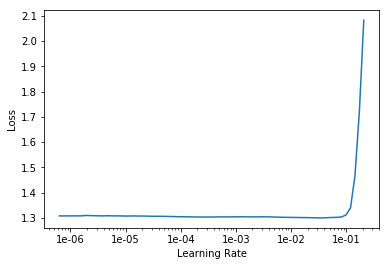

In [24]:
learn.recorder.plot()

# Training


In [25]:
learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.296093,1.285361,0.386013,02:02
1,1.278676,1.264021,0.396523,02:03
2,1.256892,1.249114,0.404689,02:04
3,1.246536,1.239743,0.410324,02:04
4,1.235608,1.233710,0.413887,02:04
5,1.231114,1.230816,0.415453,02:05
6,1.226915,1.229784,0.416034,02:05
7,1.228837,1.229620,0.416134,02:05


In [26]:
learn.save('enhancer_mouse_LM_3m1s')
learn.save_encoder('enhancer_mouse_LM_3m1s_enc')

# Classification

In [12]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab, chunksize=80000,
                                            text_cols='Sequence', label_cols='Enhancer', bs=200)

In [13]:
len(data_clas.vocab.itos), len(data_clas.vocab.stoi)

(65, 65)

In [16]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4,
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.55

In [17]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [18]:
learn = learn.to_fp16(dynamic=True);

In [21]:
learn.load_encoder('enhancer_mouse_LM_3m1s_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


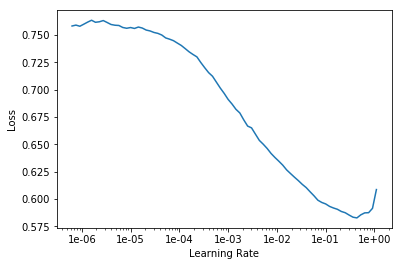

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(3, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.491756,0.491515,0.766786,01:12
1,0.476428,0.486621,0.778929,01:12
2,0.473443,0.460183,0.781429,01:12


In [24]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.466794,0.449737,0.787500,01:28
1,0.453037,0.439354,0.788214,01:28
2,0.444193,0.436169,0.790000,01:28


In [25]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.437987,0.443407,0.783929,02:10
1,0.429027,0.439007,0.786071,02:10
2,0.422084,0.440999,0.790357,02:10


In [26]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.414674,0.437434,0.791429,02:44
1,0.415789,0.438515,0.790357,02:43
2,0.411437,0.439810,0.790357,02:43


In [27]:
learn.save('enhancer_mouse_clas_finetune_3m1s')

In [19]:
learn.load('enhancer_mouse_clas_finetune_3m1s');

In [20]:
data_test = GenomicTextClasDataBunch.from_df(path, train_df, test_df, 
                                                 tokenizer=tok, vocab=model_vocab, text_cols='Sequence', 
                                                 label_cols='Enhancer', bs=200)

In [21]:
learn.data = data_test
preds = learn.get_preds(ordered=True)
p = torch.argmax(preds[0], dim=1)
y = preds[1]

In [31]:
roc_auc_score(y, preds[0][:,1])

0.8753308673469387

In [22]:
get_scores(learn)

Accuracy: 0.8003571428571429
False Positives: 0.10928571428571429
False Negatives: 0.09035714285714286
Recall: 0.8192857142857143
Precision: 0.7894012388162422
Specificity: 0.7814285714285715
MCC: 0.601145209781667


# Dog

In [5]:
classification_df = pd.read_csv(path/'enhancer_data.csv')

In [6]:
classification_df = classification_df[classification_df.Organism == 'Dog']

In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
classification_df.Organism.unique()

array(['Dog'], dtype=object)

In [9]:
train_df.shape, valid_df.shape, test_df.shape

((22400, 4), (2800, 4), (2800, 4))

In [10]:
voc = np.load(path/'mammal_vocab_3m1s.npy')
model_vocab = GenomicVocab(voc)

In [11]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=3, stride=1), n_cpus=4, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [12]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=850, tokenizer=tok, 
                              chunksize=80000, text_cols='Sequence', label_cols='Enhancer', vocab=model_vocab)

In [13]:
len(data.vocab.stoi), len(data.vocab.itos)

(65, 65)

In [16]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [17]:
learn = get_model_LM(data, drop_mult, config)

In [18]:
learn = learn.to_fp16(dynamic=True);
learn.load('mammal_3m1s');

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


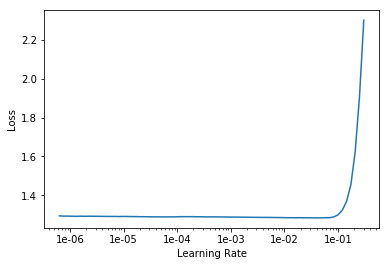

In [21]:
learn.recorder.plot()

# Training


In [22]:
learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.280225,1.269920,0.404309,02:03
1,1.249832,1.243529,0.418423,02:03
2,1.241746,1.237314,0.421562,02:03
3,1.236221,1.234344,0.423077,02:03
4,1.230810,1.232660,0.423992,02:04
5,1.229825,1.231917,0.424422,02:03
6,1.225541,1.231659,0.424221,02:04
7,1.225176,1.231635,0.424206,02:04


In [24]:
learn.save('enhancer_dog_LM_3m1s')
learn.save_encoder('enhancer_dog_LM_3m1s_enc')

# Classification

In [12]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab, chunksize=80000,
                                            text_cols='Sequence', label_cols='Enhancer', bs=200)

In [13]:
len(data_clas.vocab.itos), len(data_clas.vocab.stoi)

(65, 65)

In [16]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4,
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.45

In [17]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [18]:
learn = learn.to_fp16(dynamic=True);

In [32]:
learn.load_encoder('enhancer_dog_LM_3m1s_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


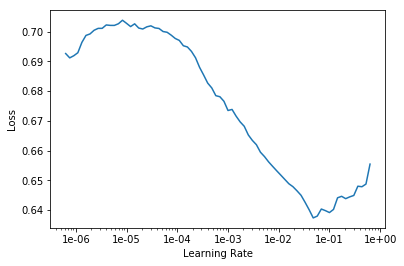

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(3, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.588694,0.568622,0.708214,01:12
1,0.580101,0.554795,0.722143,01:13
2,0.570082,0.552061,0.722857,01:13


In [35]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.568988,0.550811,0.728929,01:28
1,0.556793,0.546929,0.730000,01:29
2,0.542294,0.538945,0.735000,01:29


In [36]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.536864,0.537704,0.736786,02:11
1,0.530917,0.536300,0.737143,02:11
2,0.511223,0.537230,0.736786,02:12


In [37]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.496160,0.542295,0.730714,02:45
1,0.497164,0.539169,0.731071,02:45
2,0.497326,0.539951,0.734286,02:44


In [38]:
learn.save('enhancer_dog_clas_finetune_3m1s')

In [19]:
learn.load('enhancer_dog_clas_finetune_3m1s');

In [20]:
data_test = GenomicTextClasDataBunch.from_df(path, train_df, test_df, 
                                                 tokenizer=tok, vocab=model_vocab, text_cols='Sequence', 
                                                 label_cols='Enhancer', bs=200)

In [21]:
learn.data = data_test
preds = learn.get_preds(ordered=True)
p = torch.argmax(preds[0], dim=1)
y = preds[1]

In [46]:
roc_auc_score(y, preds[0][:,1])

0.7877551020408164

In [22]:
get_scores(learn)

Accuracy: 0.7167857142857142
False Positives: 0.1357142857142857
False Negatives: 0.1475
Recall: 0.705
Precision: 0.7220190197512801
Specificity: 0.7285714285714285
MCC: 0.43369192758417546


# Opossum

In [5]:
classification_df = pd.read_csv(path/'enhancer_data.csv')

In [6]:
classification_df = classification_df[classification_df.Organism == 'Opossum']

In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
classification_df.Organism.unique()

array(['Opossum'], dtype=object)

In [9]:
train_df.shape, valid_df.shape, test_df.shape

((22399, 4), (2800, 4), (2800, 4))

In [10]:
voc = np.load(path/'mammal_vocab_3m1s.npy')
model_vocab = GenomicVocab(voc)

In [11]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=3, stride=1), n_cpus=4, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [12]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=850, tokenizer=tok, 
                              chunksize=80000, text_cols='Sequence', label_cols='Enhancer', vocab=model_vocab)

In [13]:
len(data.vocab.stoi), len(data.vocab.itos)

(65, 65)

In [16]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [17]:
learn = get_model_LM(data, drop_mult, config)

In [18]:
learn = learn.to_fp16(dynamic=True);
learn.load('mammal_3m1s');

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


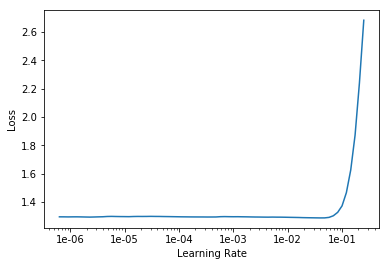

In [21]:
learn.recorder.plot()

# Training


In [22]:
learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.283674,1.279451,0.394591,02:01
1,1.263674,1.258534,0.406919,02:02
2,1.243832,1.244948,0.414548,02:03
3,1.232851,1.239051,0.418347,02:02
4,1.226843,1.235649,0.420321,02:03
5,1.222338,1.233280,0.421879,02:03
6,1.220193,1.232389,0.422406,02:03
7,1.219920,1.232288,0.422388,02:03


In [24]:
learn.save('enhancer_opossum_LM_3m1s')
learn.save_encoder('enhancer_opossum_LM_3m1s_enc')

# Classification

In [12]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab, chunksize=80000,
                                            text_cols='Sequence', label_cols='Enhancer', bs=200)

In [13]:
len(data_clas.vocab.itos), len(data_clas.vocab.stoi)

(65, 65)

In [16]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4,
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.5

In [17]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [18]:
learn = learn.to_fp16(dynamic=True);

In [19]:
learn.load_encoder('enhancer_opossum_LM_3m1s_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


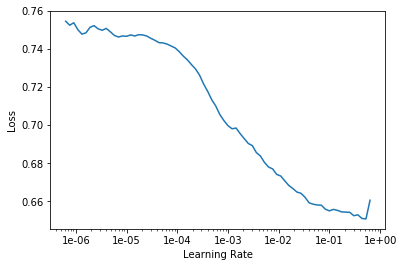

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(3, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.582051,0.572366,0.693214,01:11
1,0.573635,0.569884,0.699643,01:11
2,0.561209,0.564958,0.697143,01:11


In [22]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.560477,0.563538,0.711786,01:27
1,0.554773,0.548940,0.715357,01:27
2,0.532201,0.543050,0.720357,01:26


In [23]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.528424,0.549138,0.723929,02:08
1,0.519740,0.539840,0.725357,02:08
2,0.504494,0.545568,0.726071,02:08


In [24]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.493933,0.550572,0.727143,02:41
1,0.495443,0.548073,0.728571,02:41
2,0.486383,0.548836,0.727143,02:41


In [25]:
learn.save('enhancer_opossum_clas_finetune_3m1s')

In [27]:
learn.load('enhancer_opossum_clas_finetune_3m1s');

In [26]:
data_test = GenomicTextClasDataBunch.from_df(path, train_df, test_df, 
                                                 tokenizer=tok, vocab=model_vocab, text_cols='Sequence', 
                                                 label_cols='Enhancer', bs=200)

In [27]:
learn.data = data_test
preds = learn.get_preds(ordered=True)
p = torch.argmax(preds[0], dim=1)
y = preds[1]

In [28]:
roc_auc_score(y, preds[0][:,1])

0.7989770408163266

In [29]:
get_scores(learn)

Accuracy: 0.7246428571428571
False Positives: 0.12785714285714286
False Negatives: 0.1475
Recall: 0.705
Precision: 0.7338289962825278
Specificity: 0.7442857142857143
MCC: 0.44963282257456605
